In [1]:
.libPaths(c("~/Rlibs_fgsea", .libPaths()))

In [2]:
suppressPackageStartupMessages({
    library(Seurat)
    library(openxlsx)
    library(ggplot2)
    library(clustree)
    library(patchwork)
    library(qs)
})

In [3]:
source("../Utility/seurat_tools.r")
source("../Utility/plots.r")
source("../Utility/markers_utility.r")
source("../Utility/enrichment.r")
source("../Utility/cell_cycle_scoring.r")

In [5]:
seurat_object <- qread("../Step4_Integration/out/integrated_harmony_SCPCP000001_50_2000_3000.qs")

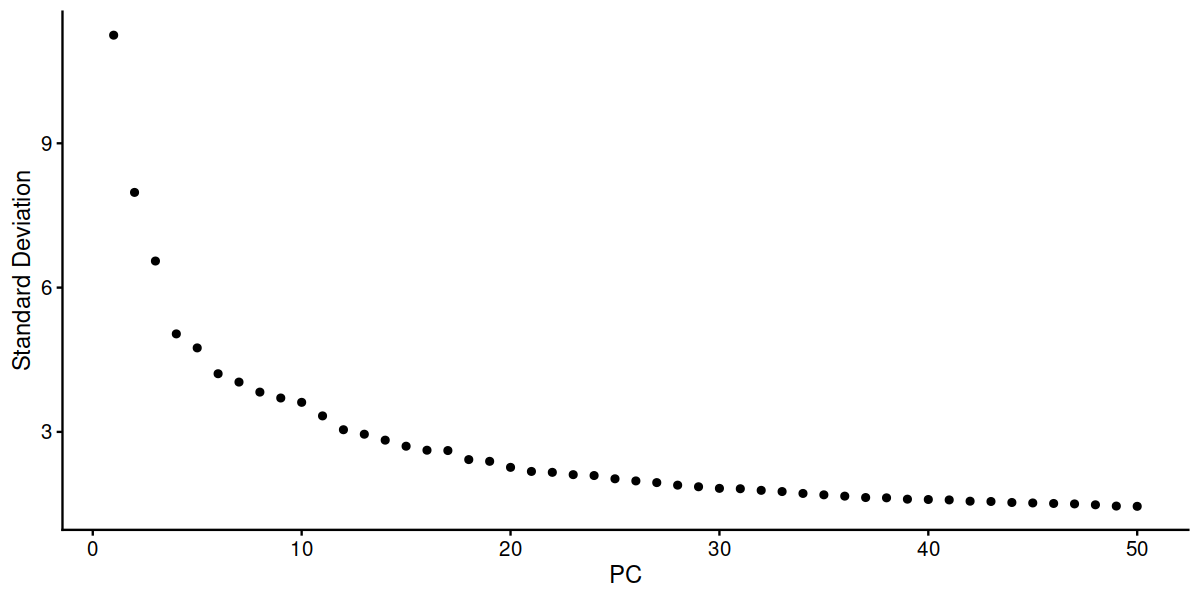

In [6]:
options(repr.plot.width=10, repr.plot.height=5)
ElbowPlot(object = seurat_object, ndims = 50)

In [ ]:
seurat_object <- RunUMAP(seurat_object, reduction = "harmony", dims = 1:30)

In [8]:
seurat_object <- FindNeighbors(seurat_object, reduction="harmony", dims = 1:30)

resolutions_to_test <- c(0.05, 0.1, 0.2, 0.3, 0.4, 0.45, 0.5)
for (res in resolutions_to_test) {
    seurat_object <- FindClusters(seurat_object, resolution = res, verbose = FALSE)
}

Computing nearest neighbor graph

Computing SNN



In [9]:
qsave(seurat_object, "harmony_clustered_SCPCP000001_50_2000_3000.qs")

In [10]:
table(seurat_object@meta.data$diagnosis, seurat_object@meta.data$age)

                   
                       4    7   10   11   12   15   17   18   21   24
  Glioblastoma       602  864  246 2063 3472 4803  336 1277  158 1075
  High-grade glioma    0  730    0    0    0  331    0    0    0    0
  Non-cancerous        0    0    0    0    0    0    0    0  564    0

In [11]:
seurat_object = subset(seurat_object, age <= 18)

In [12]:
seurat_object <- subset(seurat_object, subset=(age <= 18))

In [13]:
seurat_object <- cell_cycle_scoring(seurat_object, cc_file="../Utility/Data/CC_Homo_sapiens.csv")

loading from cache

require(“ensembldb”)



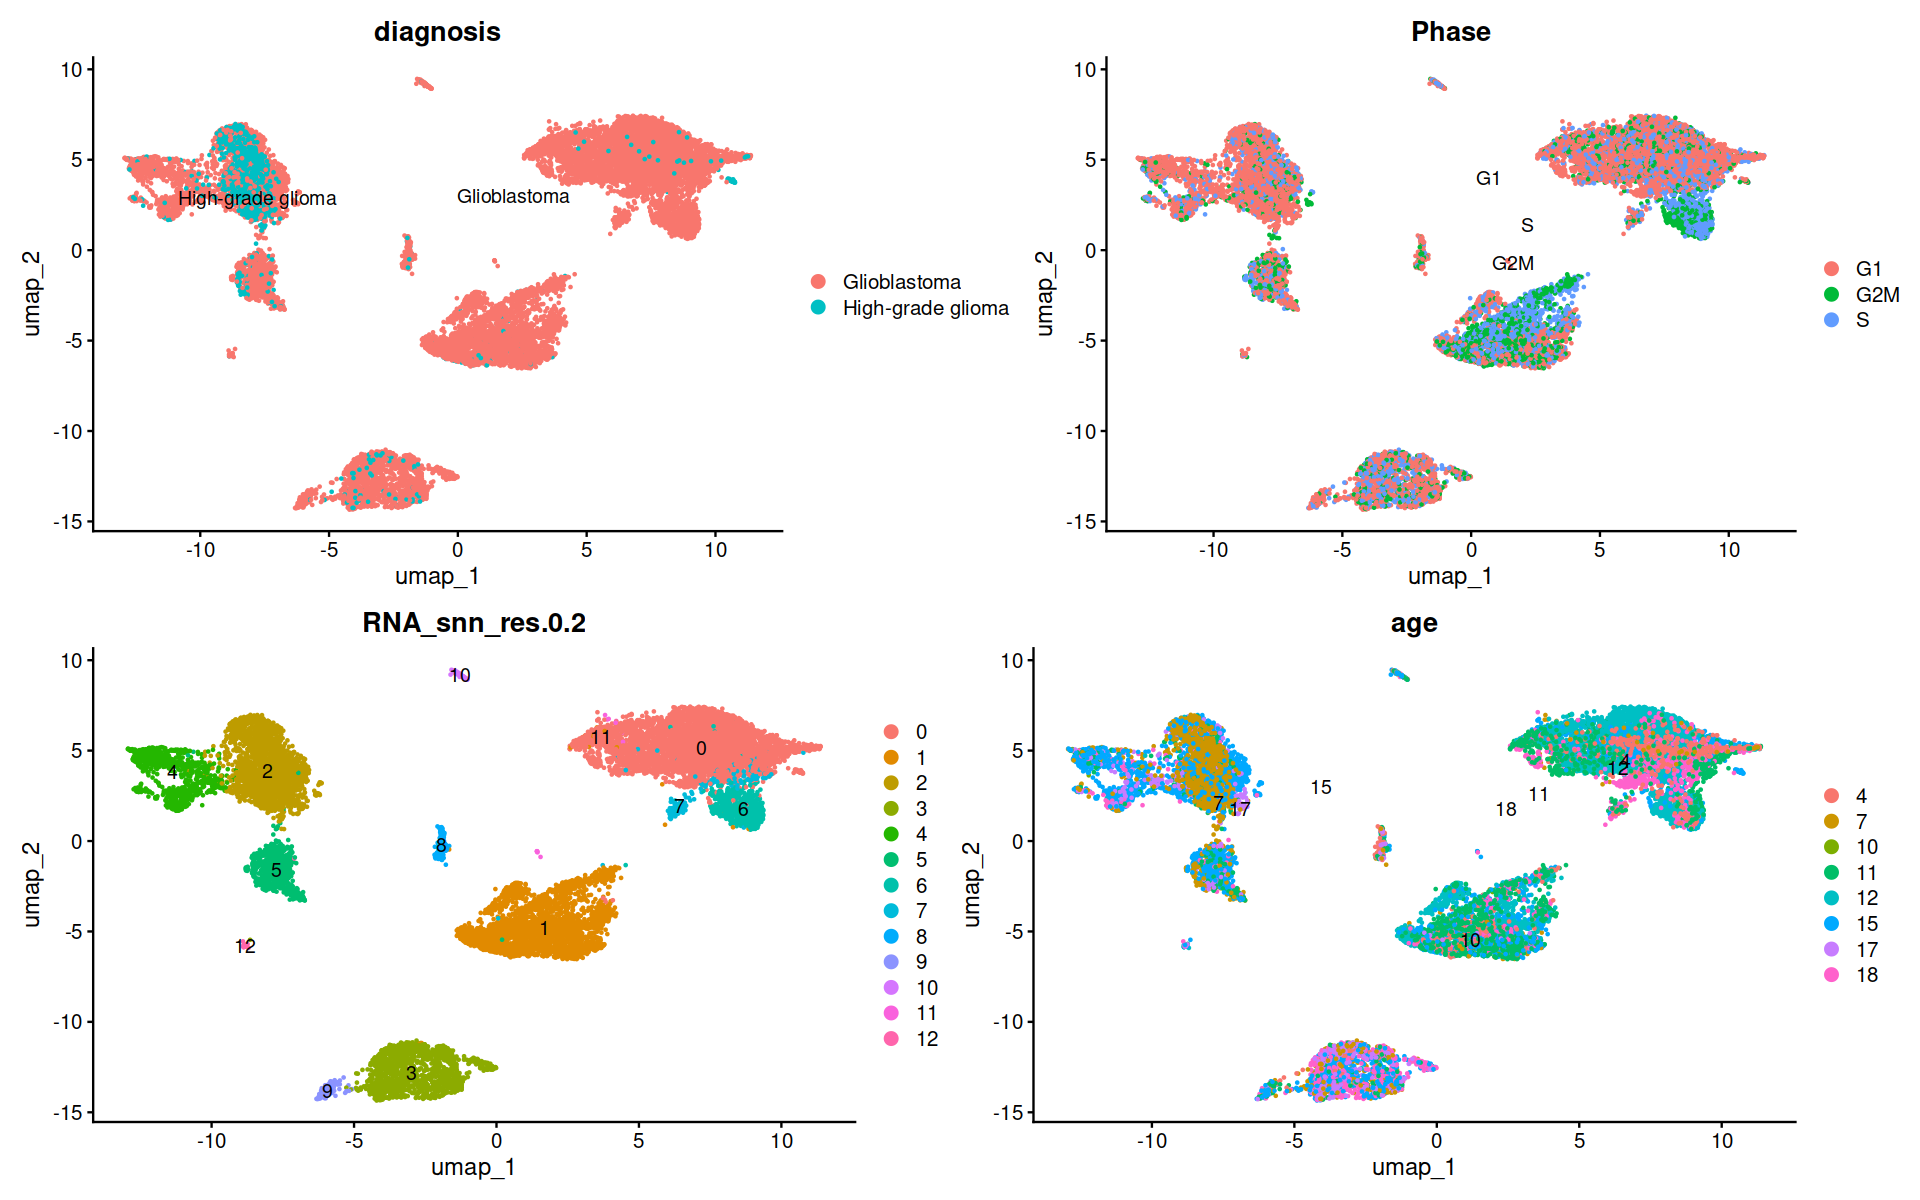

In [14]:
options(repr.plot.width=16, repr.plot.height=10)

p1 <- DimPlot(seurat_object, reduction="umap", label=TRUE, group.by="diagnosis")
p2 <- DimPlot(seurat_object, reduction="umap", label=TRUE, group.by="Phase")
p3 <- DimPlot(seurat_object, reduction="umap", label=TRUE, group.by="RNA_snn_res.0.2")
p4 <- DimPlot(seurat_object, reduction="umap", label=TRUE, group.by="age")

(p1 | p2) /
(p3 | p4)


## Pull Markers

In [15]:
seurat_object <- SetIdent(seurat_object, value="RNA_snn_res.0.2")
marker_results <- FindAllMarkers(seurat_object, min.pct = 0.3)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12



In [16]:
head(marker_results)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
NLGN1,0,2.435781,0.970,0.244,0,0,NLGN1
LRP1B,0,2.671639,0.955,0.243,0,0,LRP1B
KCND2,0,2.240037,0.958,0.255,0,0,KCND2
DLGAP1,0,2.492280,0.932,0.238,0,0,DLGAP1
LRRC4C,0,2.640360,0.903,0.212,0,0,LRRC4C
SOX5,0,2.239190,0.953,0.264,0,0,SOX5


In [17]:
cluster_markers <- split(marker_results, as.factor(marker_results$cluster))
sorted_markers <- lapply(cluster_markers, function(x) {
    sorted_markers_index <- order(x$avg_log2FC, decreasing=T)
    sorted_markers <- x[sorted_markers_index, ]
})
writexl::write_xlsx(sorted_markers, path="./out/markers_SCPCP000001_50_2000_3000.xlsx", col_names = T)

## GSEA Analysis

In [18]:
pathway_data <- load_msigdbr()

Functions below removes any pathways with P-values 0 and NA to avoid pathways with overestimated P-values

In [19]:
View(run_enrichment)

function (marker_results, pathway_data, ont = "CC") 
{
    marker_list <- split(marker_results, marker_results$cluster)
    go_output = list()
    for (cluster in names(marker_list)) {
        df <- marker_list[[cluster]]
        gene_list <- df %>% dplyr::filter(!is.na(avg_log2FC)) %>% 
            dplyr::filter(!is.na(p_val_adj)) %>% dplyr::filter(p_val_adj <= 
            0.05) %>% arrange(desc(avg_log2FC)) %>% distinct(gene, 
            .keep_all = TRUE)
        gene_list$entrez <- mapIds(org.Hs.eg.db, keys = gene_list$gene, 
            column = "ENTREZID", keytype = "SYMBOL", multiVals = "first")
        ranked_genes <- gene_list$avg_log2FC
        names(ranked_genes) <- gene_list$entrez
        ranked_genes <- sort(ranked_genes, decreasing = TRUE)
        ranked_genes <- ranked_genes[!is.na(names(ranked_genes))]
        out <- run_gseago(ranked_genes, pathway_data, ont)
        print(paste0("Cluster ", as.character(cluster)))
        go_output[[cluster]] <- out
    }
    return(go_output)
}

In [20]:
View(plot_pathway_heatmap)

function (gsea_output, cell_order, left_margin = unit(2, "cm")) 
{
    plot_data_list <- list()
    for (cluster in names(gsea_output)) {
        res <- as.data.frame(gsea_output[[cluster]])
        if (nrow(res) > 0) {
            res <- res %>% dplyr::filter(NES != 0) %>% dplyr::filter(p.adjust <= 
                0.05)
            res$Cluster <- cluster
            plot_data_list[[cluster]] <- res[, c("Description", 
                "NES", "Cluster")]
        }
    }
    plot_data_combined <- do.call(rbind, plot_data_list)
    plot_mat <- reshape2::dcast(plot_data_combined, Description ~ 
        Cluster, value.var = "NES")
    rownames(plot_mat) <- plot_mat$Description
    plot_mat$Description <- NULL
    plot_mat[is.na(plot_mat)] <- 0
    valid_cell_order <- intersect(cell_order, colnames(plot_mat))
    if (length(valid_cell_order) == 0) {
        stop("None of the provided cell_order values match the columns in the data matrix.")
    }
    plot_mat <- plot_mat[, valid_cell_order, drop = FALSE]
    dominant_cluster <- apply(plot_mat, 1, assign_dominant_cluster, 
        plot_mat = plot_mat)
    pathway_order_df <- data.frame(Pathway = rownames(plot_mat), 
        DominantCellType = dominant_cluster, MaxNES = apply(plot_mat, 
            1, max), stringsAsFactors = FALSE)
    pathway_order_df$DominantCellType <- factor(pathway_order_df$DominantCellType, 
        levels = valid_cell_order)
    pathway_order_df <- pathway_order_df %>% arrange(DominantCellType, 
        desc(MaxNES))
    plot_mat_ordered <- plot_mat[pathway_order_df$Pathway, , 
        drop = FALSE]
    plot_mat_ordered <- plot_mat_ordered[rowSums(plot_mat_ordered > 
        0) > 0, , drop = FALSE]
    plot <- pheatmap(plot_mat_ordered, scale = "row", cluster_rows = FALSE, 
        cluster_cols = FALSE, fontsize_col = 24, fontsize_row = 12, 
        cell_height = 10, border = TRUE, color = colorRampPalette(c("dodgerblue4", 
            "white", "darkred"))(100), border_color = "white", 
        show_rownames = TRUE, show_colnames = TRUE, fontfamily = "sans", 
        angle_col = 45, silent = TRUE, main = "")
    plot$gtable$widths[2] <- plot$gtable$widths[2] + left_margin
    return(plot)
}

In [ ]:
gsea_output <- run_enrichment(marker_results, pathway_data=pathway_data, ont="CC") 


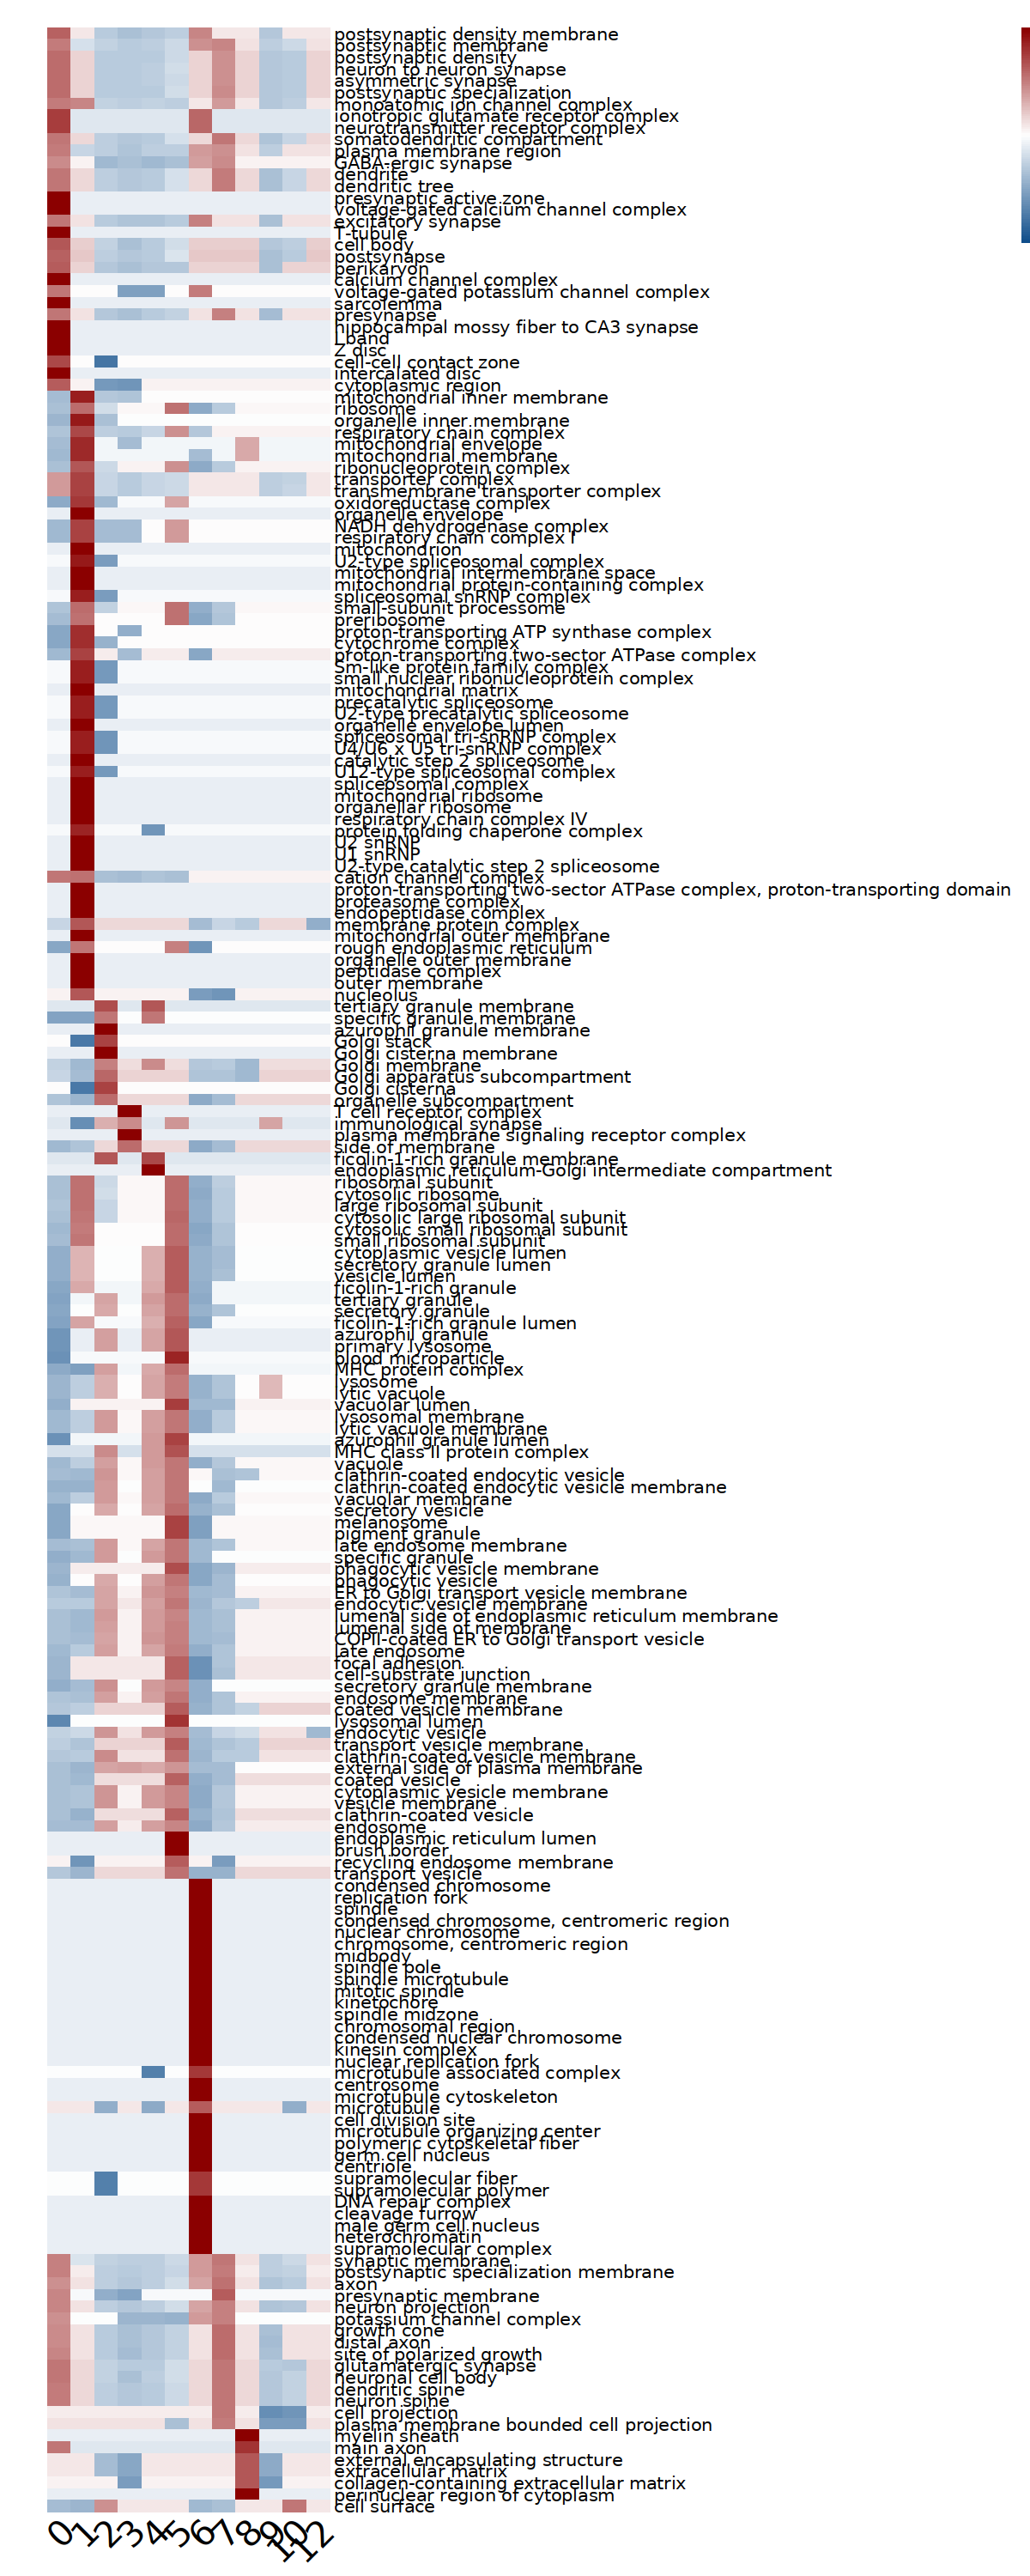

In [22]:
options(repr.plot.width=10, repr.plot.height=25)
plot <- plot_pathway_heatmap(gsea_output, cell_order=names(gsea_output))
plot

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


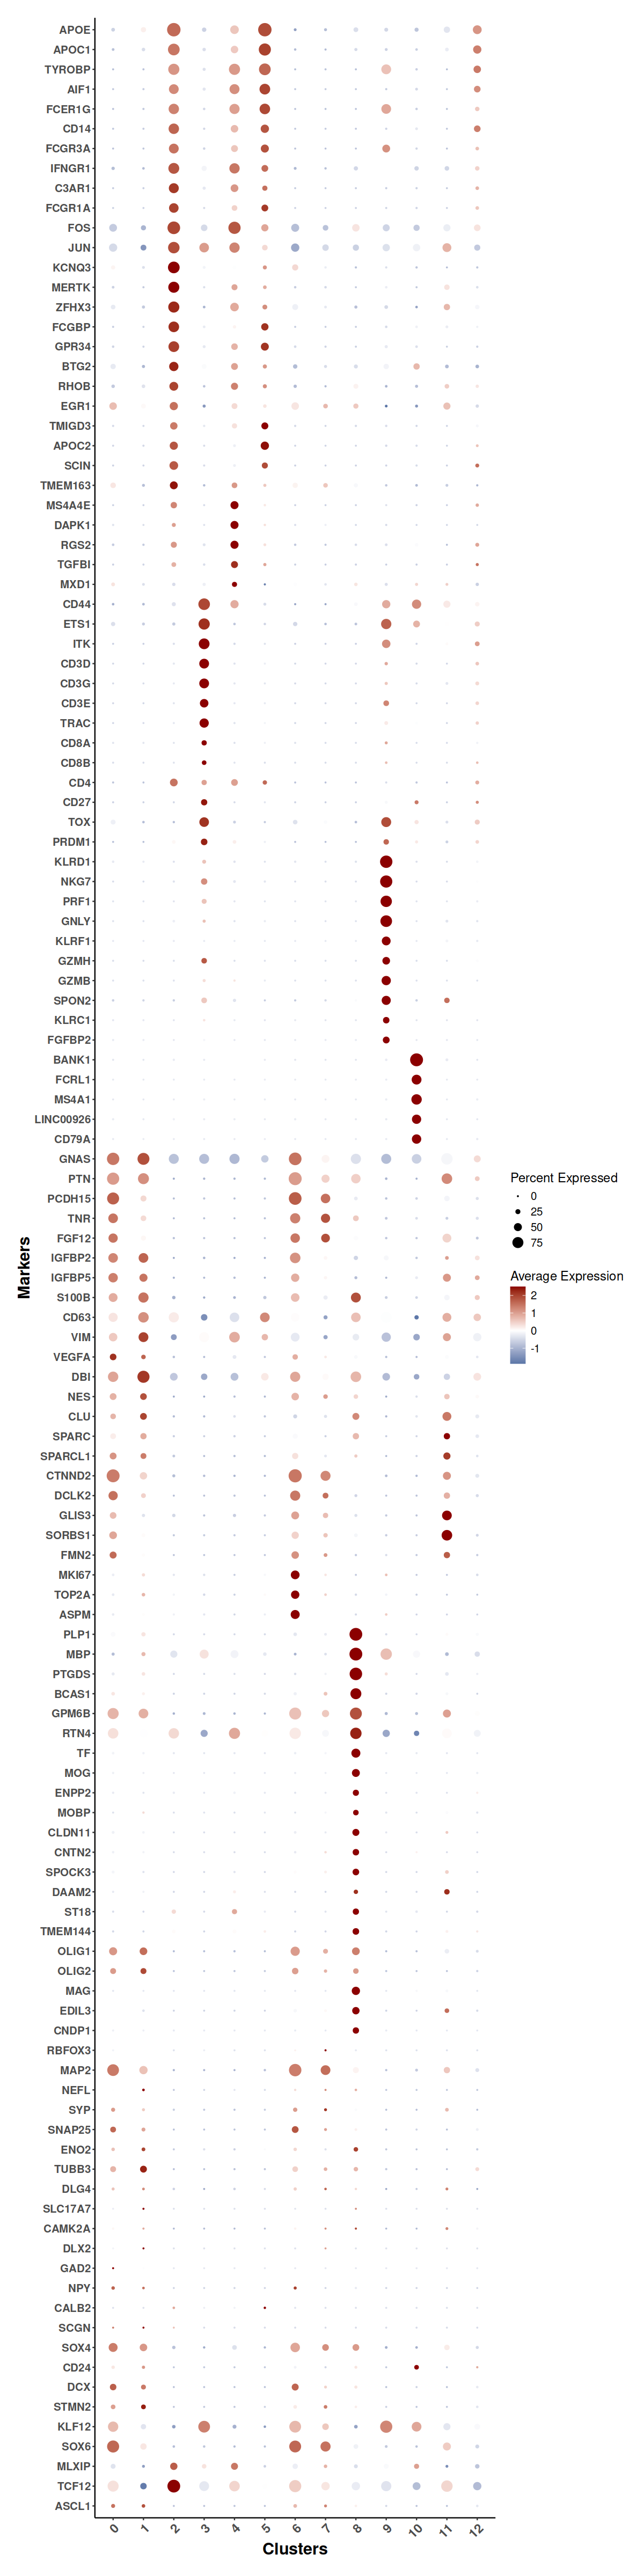

In [31]:
options(repr.plot.width=10, repr.plot.height=40)


marker_list_general <- list(
    'Macrophage'                                  = c("APOE",'APOC1','CD206','TYROBP','AIF1','FCER1G','CD14','FCGR3A','IFNGR1','C3AR1','FCGR1A','CX3XR1'),
    'Homeostatic/Transitioning Macrophage'        = c( "FOS","JUN","KCNQ3","MERTK","ZFHX3","FCGBP","P2RY","GPR34","BTG2","PRP14B","RHOB","EGR1"),
    
    'Microglia Derived TAMs'                      = c('TMIGD3', 'APOC2', 'SCIN'),
    "Bone-marrow Derived TAM"                     = c("TMEM163", "MS4A4E", "DAPK1","RGS2", "TGFBI","MXD1"),
    
    "T Cell"                                      = c('CD44','ETS1','ITK','CD3D','CD3G','CD3E','ILR','TRAC',"CD8A","CD8B",'CD4','CD27'),
    "T Cell Exhausted"                            = c('TOX','PRDM1'),
    "NK"                                          = c('KLRD1','NKG7','PRF1','GNLY','KLRF1','GZMH','GZMB','SPON2','CD56','KLRC1','FGFBP2'),
    
    'Naive B'                                     = c('BANK1','FCRL1','MS4A1','LINC00926','CD79A'),
    
    'MES-like'                                    = c('GNAS','PTN','PCDH15','TNR','FGF12','IGFBP2','IGFBP5','S100B','CD63','VIM','VEGFA'),
    'APC-like'                                    = c('DBI','CD63','NES','CLU','SPARC','SPARCL1'),
    'AC-like'                                     = c('CTNND2','DCLK2','GLIS3','ITRP2','SORBS1','FMN2','DCLR1'),
    
    'Cycling'                                     = c('MKI67','TOP2A','ASPM'),
    
    'OPC-like'                                    = c('PLP1','MBP','PTGDS','BCAS1','GPM6B','RTN4','TF','MOG','ENPP2','MOBP','CLDN11','UG8T','SBCA2','CNTN2','SPOCK3','DAAM2','ST18','TMEM144','ENPP2'),
    'OC-like'                                     = c('OLIG1','OLIG2','BCAS1','MAG','EDIL3','CNDP1','TF','PLP1','MOG','MBP'),
    
    'Neuron'                                      = c('RBFOX3', 'MAP2', 'NEFL', 'SYP', 'SNAP25', 'ENO2', 'TUBB3', 'DLG4','SLC17A7','CAMK2A'),
    'NEU-like'                                    = c('DLX2','GAD2','NPY','CALB2','SCGN','GSX2','SOX4','CD24','DCX','STMN2'),
    'NPC-like'                                    = c('KLF12', 'SOX6', 'MLXIP','TCF12', 'ASCL1')
)

marker_order <- names(marker_list_general)
all_markers <- rev(unique(unname(unlist(marker_list_general[marker_order]))))
all_markers <- factor(all_markers, levels = all_markers)

existing_markers <- all_markers[all_markers %in% rownames(seurat_object)]
p <- DotPlot(seurat_object, 
                features = existing_markers, 
                 group.by = "RNA_snn_res.0.2", 
                 cols = c("dodgerblue4","white","darkred"),
                ) +
            scale_colour_gradient2(low = "dodgerblue4", mid = "white", high = "darkred") +
            theme_classic() +
            labs(y = "Clusters", x="Markers") +
                theme(
                     plot.margin = margin(20, 20, 20, 20, "pt"),
                     axis.title.y = element_text(face = "bold", size = 18),
                     axis.text.y = element_text(face = "bold", size = 12),
                     axis.title.x = element_text(face = "bold", size = 18),
                     axis.text.x = element_text(face = "bold", size = 14, angle=45),
                     legend.text = element_text(size = 12),      
                     legend.title = element_text(size = 14)
                ) +
            RotatedAxis() + coord_flip()



p



In [49]:
cluster_annotation <- c(
  '0' = 'MES-AC-like',
  '1' = 'MES-APC-like',
  '2' = 'MGD Macrophage',
  '3' = 'T cells',
  '4' = 'MD Macrophage',
  '5' = 'MGD TAM',
  '6' = 'MES-AC-like Cycling',
  '7' = 'MES-AC-like',
  '8' = 'OPC-like',
  '9' = 'NK cells',
  '10' = 'Naive B',
  '11' = 'MES-AC-like',
  '12' = 'Undetermined'
)

In [50]:
Idents(seurat_object) <- "RNA_snn_res.0.2"
seurat_object <- RenameIdents(seurat_object, cluster_annotation)
seurat_object$cell_label <- Idents(seurat_object)

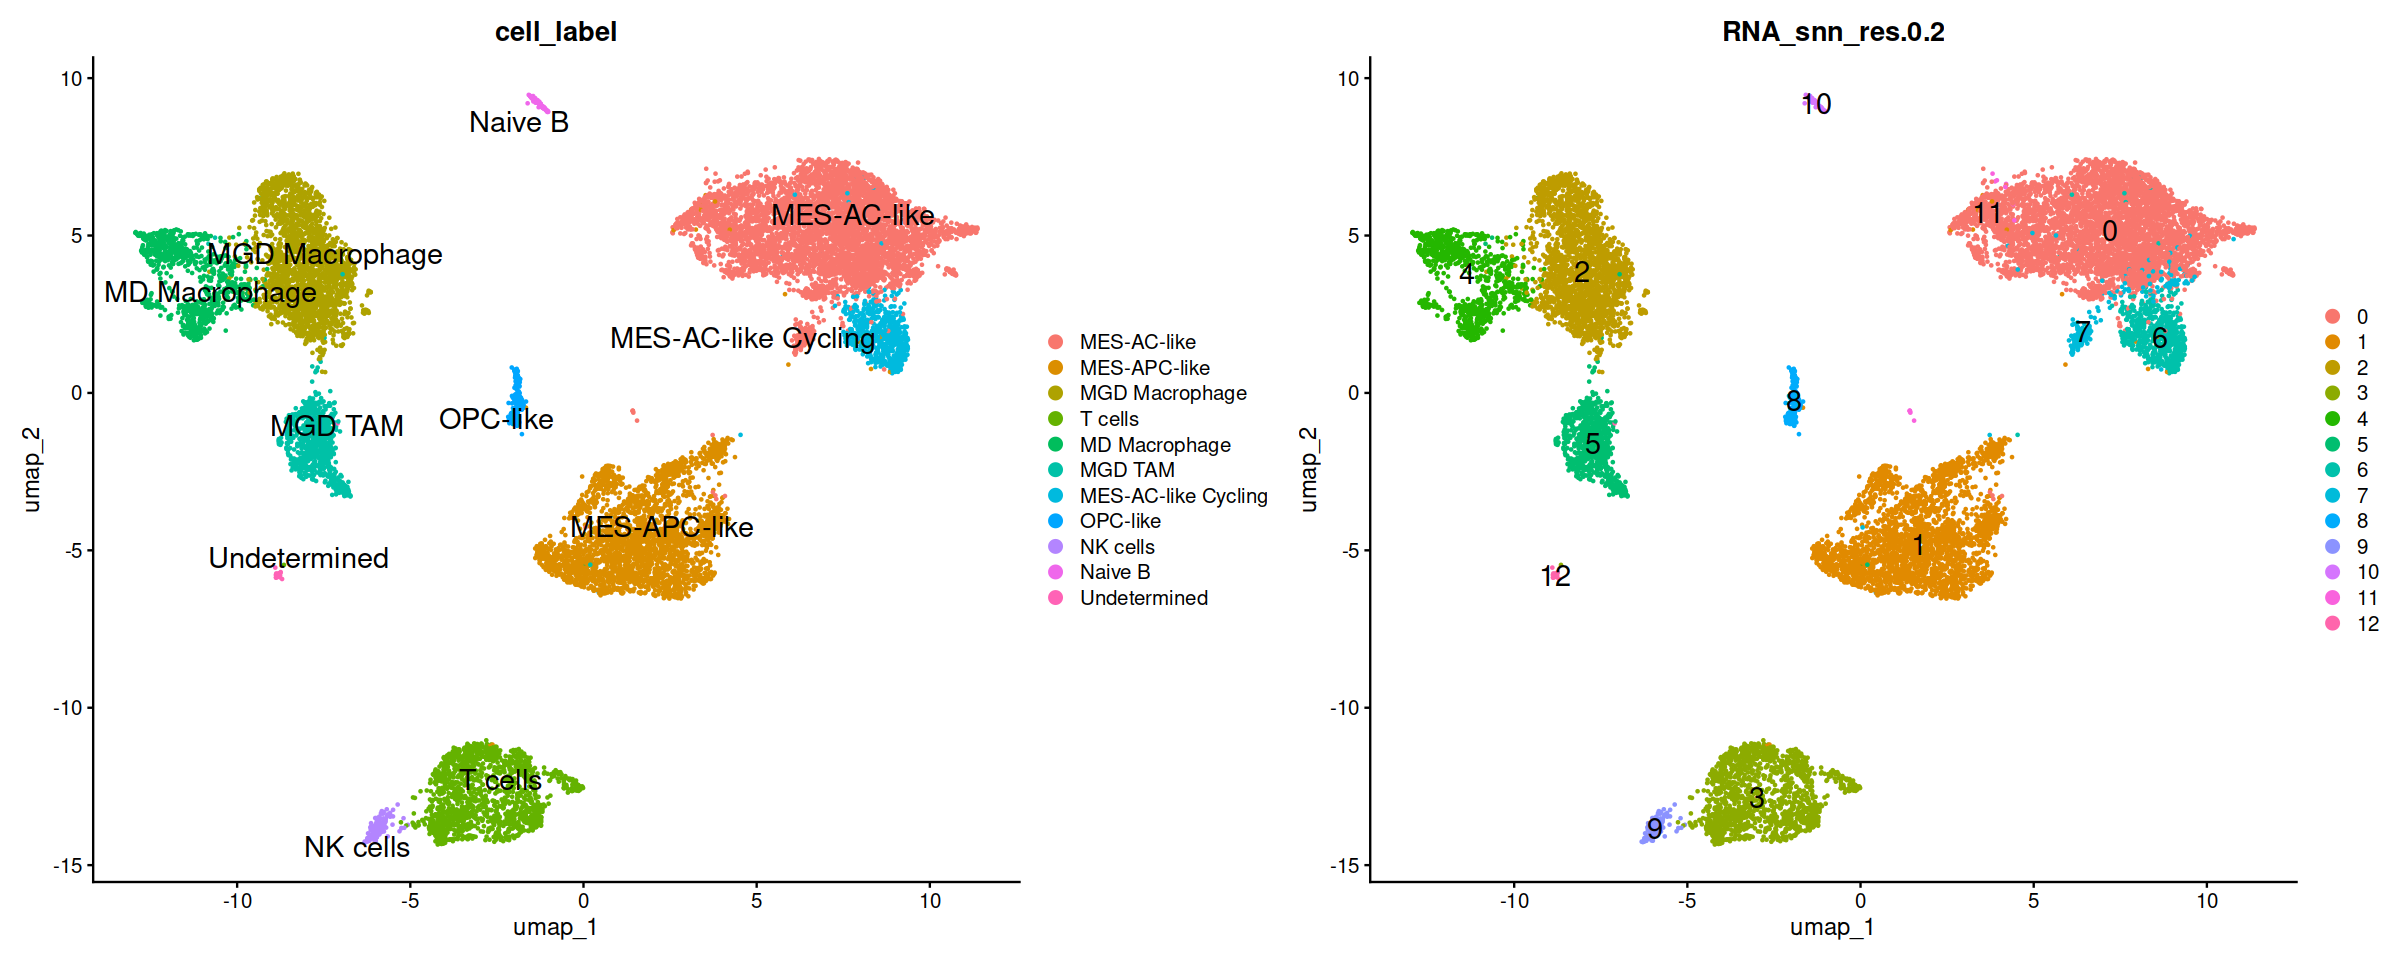

In [51]:
options(repr.plot.width=20, repr.plot.height=8)
p1 <- DimPlot(seurat_object, group.by="cell_label", label=TRUE, label.size = 6, repel = TRUE)
p2 <- DimPlot(seurat_object, group.by="RNA_snn_res.0.2", label=TRUE,label.size = 6)
p1 | p2

In [52]:
qsave(seurat_object, "./out/SCPCP000001/annotated_harmony_SCPCP000001_50_2000_3000.qs")

In [53]:
saveRDS(seurat_object, "./out/SCPCP000001/annotated_harmony_SCPCP000001_50_2000_3000.rds")

In [54]:
seurat_object <- SetIdent(seurat_object, value="cell_label")
marker_results <- FindAllMarkers(seurat_object, min.pct = 0.3)

Calculating cluster MES-AC-like

Calculating cluster MES-APC-like

Calculating cluster MGD Macrophage

Calculating cluster T cells

Calculating cluster MD Macrophage

Calculating cluster MGD TAM

Calculating cluster MES-AC-like Cycling

Calculating cluster OPC-like

Calculating cluster NK cells

Calculating cluster Naive B

Calculating cluster Undetermined



In [ ]:
gsea_output <- run_enrichment(marker_results, pathway_data=pathway_data, ont="CC") 

In [56]:
qsave(gsea_output, "./out/SCPCP000001/gsea_harmony_SCPCP000001_50_2000_3000.qs")

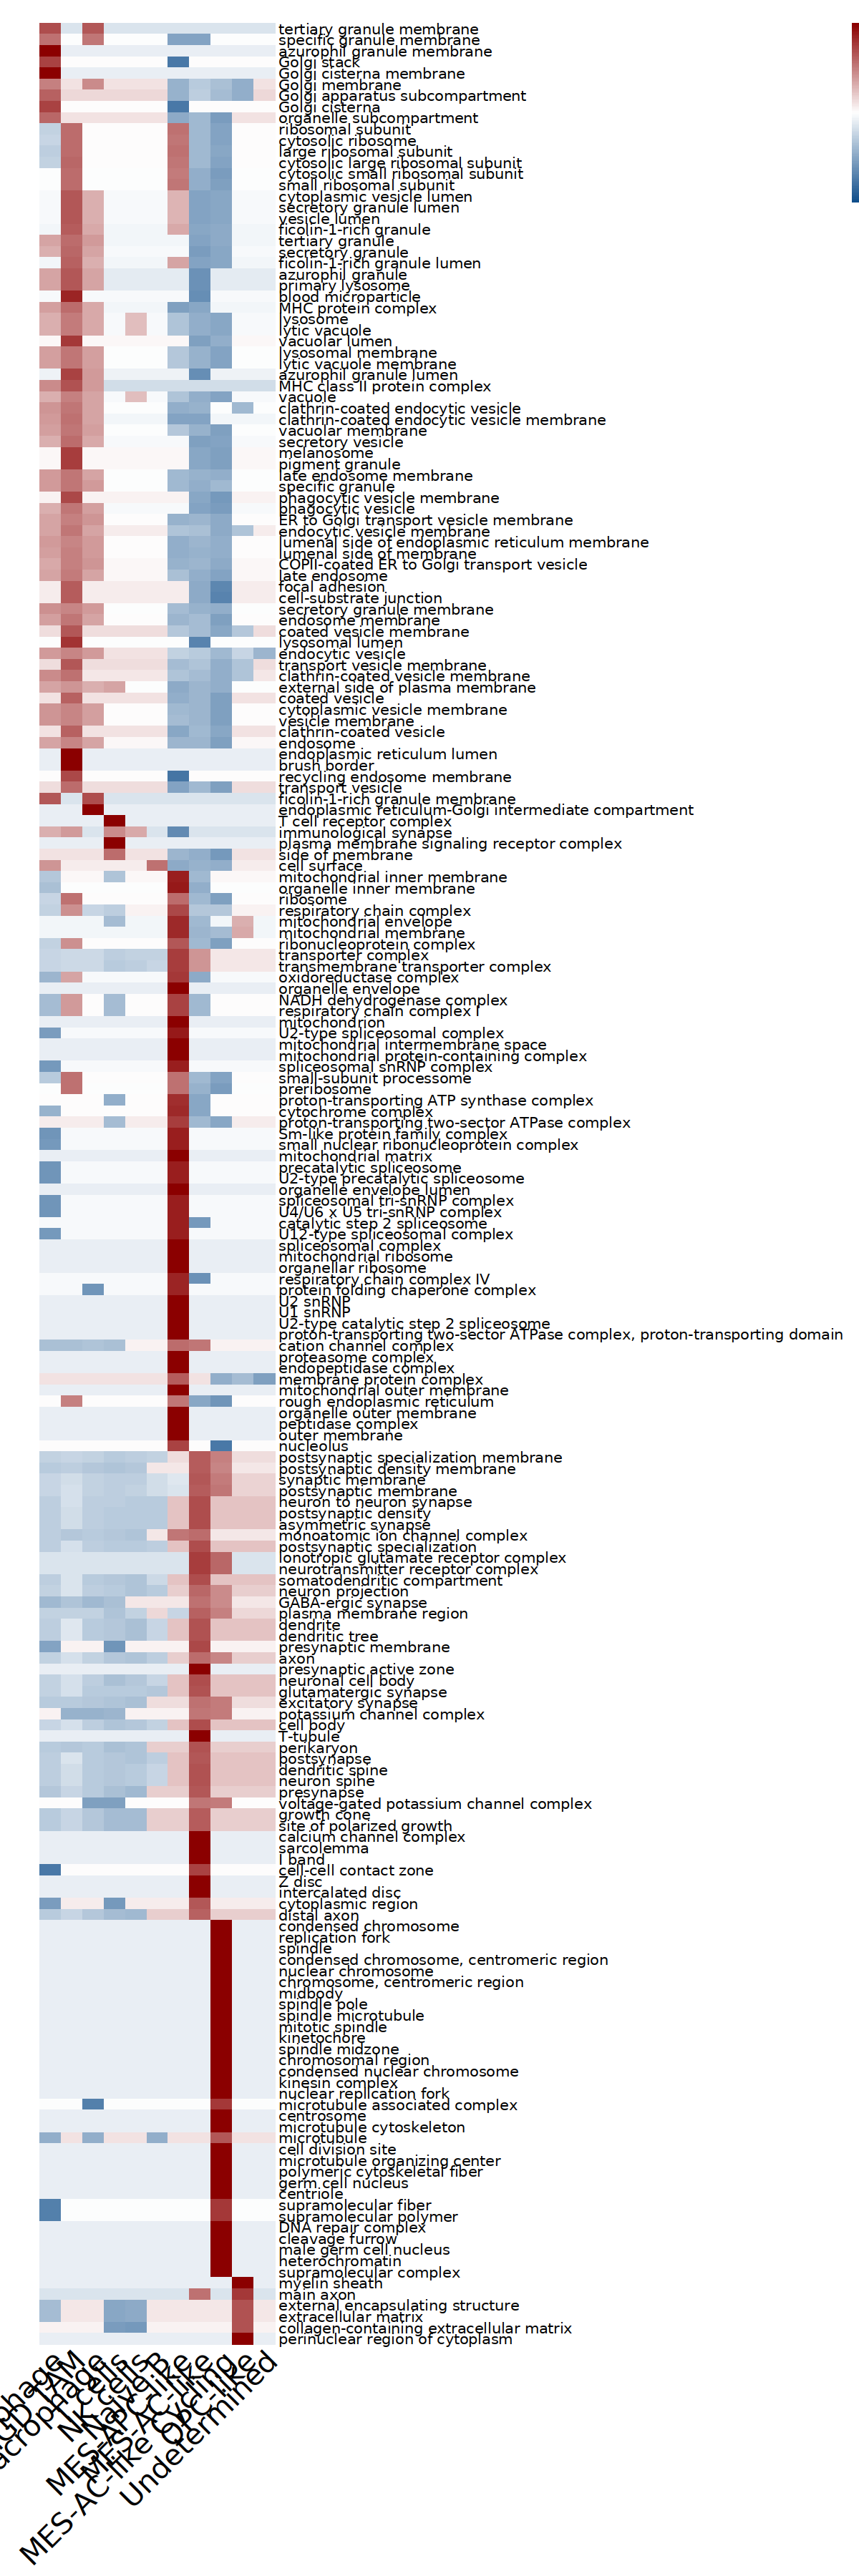

In [57]:
options(repr.plot.width=10, repr.plot.height=30)
plot <- plot_pathway_heatmap(gsea_output, cell_order=c("MGD Macrophage",
                                                       "MGD TAM",
                                                       "MD Macrophage",
                                                       "T cells",
                                                       "NK cells",
                                                       "Naive B",
                                                       "MES-APC-like",
                                                       "MES-AC-like",
                                                       "MES-AC-like Cycling",
                                                       "OPC-like",
                                                       "Undetermined"
                                                      ))
plot

